## QA (question answering)

最常用是提取式QA（extractive QA），搜索阶段（关键词检索海量文档）-> 提取答案

/Users/admin/miniconda3/envs/DL_learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']
DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})
{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answ

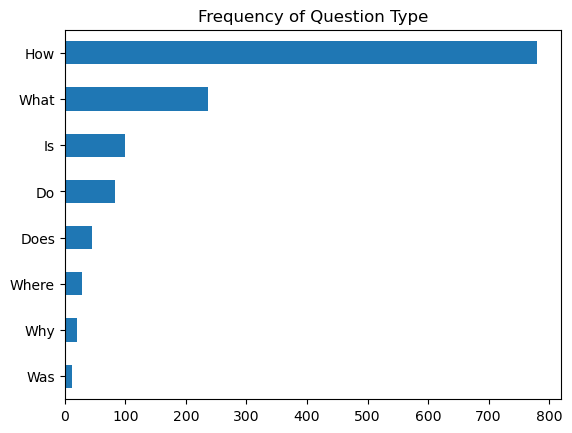

In [1]:
from datasets import load_dataset, get_dataset_config_names
from matplotlib import pyplot as plt

domains = get_dataset_config_names('subjqa', trust_remote_code=True)
print(domains)

from datasets import load_dataset
subjqa_dataset = load_dataset('subjqa', name="electronics")
print(subjqa_dataset)
print(subjqa_dataset['train']['answers'][1])

import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa_dataset.flatten().items()}
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")
    
qa_cols = ["title", "question", "answers.text",
 "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df
## I really like this keyboard.  I give it 4 stars because it doesn't have a CAPS LOCK key so I never know if my caps are on.  But for the price, it really suffices as a wireless keyboard.  I have very large hands and this keyboard is compact, but I have no complaints.
start_idx = sample_df["answers.answer_start"].iloc[0][0]
print(start_idx)
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
print(end_idx)
sample_df["context"].iloc[0][start_idx:end_idx]

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was","Where","Why"]
for q in question_types:
    counts[q] = dfs['train']['question'].str.startswith(q).value_counts()[True]
    
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Type")
plt.show()

## Tokenization for QA

In [12]:
from transformers import AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.